### **Table of Contents**
    
* [Error Handling](#error-handling)
* [Exploration and Cleaning](#exploration-and-cleaning)
  * [EDA Function](#eda-function)
  * [K Count](#k-count)
  * [HUD](#hud)
* [Keep this file in your project](#keep-this-file-in-your-project)

In [28]:
from __future__ import annotations

import json
import os
from pathlib import Path
from typing import Dict, Union, Optional

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from cycler import cycler
from highlight_text import ax_text

# Error Handling

In [29]:
def read_excel_strict(
    filepath: Union[str, Path],
    sheet_name: Optional[Union[str, int]] = 0,
    **kwargs
) -> Union[pd.DataFrame, Dict[str, pd.DataFrame]]:
    """
    Read an Excel file with predictable behavior and no side effects.

    - Raises:
        FileNotFoundError: if the file path doesn't exist.
        ValueError: if pandas cannot read the file or returns an empty result.
    - Returns:
        - DataFrame when `sheet_name` is a name/index.
        - dict[str, DataFrame] when `sheet_name=None`.

    Notes:
        Keep this function 'pure' (no prints). Let callers decide how to log/print.
    """
    path = Path(filepath)
    if not path.exists():
        raise FileNotFoundError(f"Excel file not found: {path}")

    result = pd.read_excel(path, sheet_name=sheet_name, **kwargs)

    if sheet_name is None:
        if not isinstance(result, dict) or len(result) == 0:
            raise ValueError(f"No sheets returned from: {path}")
        return {str(k): v for k, v in result.items()}

    if not isinstance(result, pd.DataFrame) or result.empty:
        raise ValueError(f"Empty or invalid DataFrame from: {path}, sheet={sheet_name}")

    return result


# Cleaning

## Shared Cleaning Helpers

In [30]:
def standardize_columns_basic(df: pd.DataFrame) -> pd.DataFrame:
    """
    Basic column cleanup shared across datasets:
    - strip whitespace
    - replace internal whitespace with single underscores
    """
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
    )
    return df


def convert_numeric_columns(
    df: pd.DataFrame,
    exclude: Optional[list[str]] = None
) -> pd.DataFrame:
    """
    Convert columns to numeric where possible, skipping any in `exclude`.
    Non-numeric values become NaN.
    """
    df = df.copy()
    if exclude is None:
        exclude = []

    numeric_candidates = [c for c in df.columns if c not in exclude]
    df[numeric_candidates] = df[numeric_candidates].apply(pd.to_numeric, errors="coerce")
    return df

## K Count Data

In [31]:
def load_kcount_raw(filepath: str) -> pd.DataFrame:
    """
    Read raw Kentucky KCount Excel data (header starts on row 2).
    """
    return read_excel_strict(filepath, header=2)


def filter_kcount_valid_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Keep only rows with a county name.
    """
    df = df[df["County"].notna()].copy()
    return df


def clean_kcount_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize column names, drop duplicate columns, and rename for clarity.
    """
    df = df.copy()

    # Shared basic cleanup
    df = standardize_columns_basic(df)

    # Remove symbols specific to KCount
    df.columns = df.columns.str.replace(r"[\*\(\)]", "", regex=True)

    # Drop duplicate columns
    df = df.drop(
        columns=["Total_Number_of_persons.1", "Total_Number_of_persons.2"],
        errors="ignore"
    )

    # Rename long columns
    rename_map = {
        "County": "county",
        "KY_Balance_of_State_CoC_Region": "coc_region",
        "KY_Area_Development_District_Balance_of_State_Coordinated_Entry_Local_Prioritization_Community": "add_region",
        "Total_Homeless": "total_homeless",
        "Population_Estimates_2024_most_recent_available_in_2025": "population_2024",
        "Percentage_of_Population": "percent_of_population",
        "Total_Number_of_persons": "total_persons",
        "Total_Number_of_Veterans": "veterans",
        "Total_Number_of_Chronically_Homeless_Persons": "chronically_homeless",
        "Adults_with_Serious_Mental_Illness_self-reported": "serious_mental_illness",
        "Adults_with_a_Substance_Use_Disorder_self-reported": "substance_use_disorder",
        "Adults_with_HIV/AIDS_self-reported": "hiv_aids",
        "Adults_whose_current_episode_of_homelessness_caused_by_domestic_violence_self-reported": "domestic_violence",
    }
    df = df.rename(columns=rename_map)

    return df


def drop_kcount_summary_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove state-level summary rows (Kentucky, Balance of State).
    """
    df = df[~df["county"].isin(["Kentucky", "Balance of State"])].copy()
    return df


def get_kcount_data(filepath: str) -> pd.DataFrame:
    """
    Master function: read + clean KCount data.
    This is the one you will usually call.
    """
    df = load_kcount_raw(filepath)
    df = filter_kcount_valid_rows(df)
    df = clean_kcount_columns(df)
    df = convert_numeric_columns(
        df,
        exclude=["county", "coc_region", "add_region"]
    )
    df = drop_kcount_summary_rows(df)
    df = df.reset_index(drop=True)
    return df


## HUD

In [32]:
def load_hud_raw(filepath: str) -> Dict[str, pd.DataFrame]:
    """
    Read all HUD sheets from Excel. Each sheet is one year.
    """
    return read_excel_strict(filepath, sheet_name=None, header=1)


def add_hud_year_column(hud_sheets: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Add a 'year' column to each sheet and concatenate into one DataFrame.
    """
    frames = []
    for year, df in hud_sheets.items():
        temp = df.copy()
        temp["year"] = str(year)
        frames.append(temp)

    hud_all = pd.concat(frames, ignore_index=True)
    return hud_all


def filter_hud_state_rows(hud_all: pd.DataFrame) -> pd.DataFrame:
    """
    Keep only rows where 'State' is a 2-letter abbreviation (remove footnotes).
    """
    hud_all = hud_all[hud_all["State"].str.len() == 2].copy()
    return hud_all


def clean_hud_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize HUD column names.
    """
    df = df.copy()

    # Shared basic cleanup
    df = standardize_columns_basic(df)

    # HUD-specific cleanup
    df.columns = (
        df.columns
        .str.replace(r"[\(\)\n]", "", regex=True)
        .str.replace(r"[^A-Za-z0-9_]+", "", regex=True)
        .str.lower()
    )
    return df


def drop_sparse_columns(df: pd.DataFrame, min_non_na_ratio: float = 0.7) -> pd.DataFrame:
    """
    Drop columns with more than 30% missing data (keep columns with at least
    `min_non_na_ratio` non-NaN values).
    """
    threshold = len(df) * min_non_na_ratio
    return df.dropna(thresh=threshold, axis=1)


def convert_hud_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert HUD numeric columns to numeric, keeping ID/text columns as strings.
    """
    non_numeric = [
        "state",
        "continuum_of_care_coc",
        "hud_coc_number",
        "ahar_part_1_coc_category",
        "year",
    ]
    return convert_numeric_columns(df, exclude=non_numeric)


def filter_hud_kentucky(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter HUD data to Kentucky only.
    """
    return df[df["state"] == "KY"].copy()


def get_hud_data(filepath: str) -> pd.DataFrame:
    """
    Master function: read + clean HUD data and return Kentucky subset.
    """
    hud_sheets = load_hud_raw(filepath)
    hud_all = add_hud_year_column(hud_sheets)
    hud_all = filter_hud_state_rows(hud_all)
    hud_all = clean_hud_columns(hud_all)
    hud_all = convert_hud_numeric(hud_all)
    hud_all = drop_sparse_columns(hud_all)
    hud_ky = filter_hud_kentucky(hud_all)
    hud_ky = hud_ky.reset_index(drop=True)
    return hud_ky

# Plots

## Shared Plot Helpers

In [33]:
PALETTE = ['#FEBE10', '#1D1E9E', '#AD0000', '#000000', '#FFFFFF']


def apply_house_style() -> None:
    """
    Apply shared plot style so all project visuals look consistent.
    """
    plt.rcParams.update({
        'axes.prop_cycle': cycler('color', PALETTE),
        'figure.facecolor': 'lightgrey',
        'axes.facecolor': 'lightgrey',
        'axes.grid': True,
        'grid.color': '#000000',
        'grid.alpha': 0.1,
        'grid.linestyle': '--',
        'font.family': 'DejaVu Sans',
        'text.color': '#000000',
        'axes.labelcolor': '#000000',
        'axes.edgecolor': '#000000'
    })


formatter = mticker.StrMethodFormatter("{x:,.0f}")


def _is_number(s: str) -> bool:
    """Helper to check if string can be converted to float."""
    try:
        float(str(s).replace(',', ''))
        return True
    except ValueError:
        return False


def apply_formatter(ax=None) -> None:
    """
    Automatically format numeric axes with commas, leave text/categorical axes alone.
    """
    if ax is None:
        ax = plt.gca()

    x_labels = [lbl.get_text() for lbl in ax.get_xticklabels()]
    if x_labels and all(_is_number(lbl) for lbl in x_labels):
        ax.xaxis.set_major_formatter(formatter)

    y_labels = [lbl.get_text() for lbl in ax.get_yticklabels()]
    if y_labels and all(_is_number(lbl) for lbl in y_labels):
        ax.yaxis.set_major_formatter(formatter)

## Highest Homeless Population by County

In [34]:
def plot_top10_counties(
    df: pd.DataFrame,
    output_path: str = "../ashley/plots/top10_homeless_counties.png",
    analyst: str = "Ashley Skidmore",
) -> None:
    """
    Plot the Top 10 Kentucky counties by total homeless population.

    Args:
        df: Cleaned KCount DataFrame containing 'county' and 'total_homeless' columns.
        output_path: Path to save the PNG file.
        analyst: Name to credit on the plot.

    Returns:
        None (saves a PNG plot and shows it).
    """
    # Validate columns
    required = {"county", "total_homeless"}
    if not required.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required - set(df.columns)}")

    apply_house_style()

    # Data prep
    kcount_sorted = (
        df.sort_values("total_homeless", ascending=False)
        .head(10)
        .reset_index(drop=True)
    )

    # Plot setup
    plt.figure(figsize=(10, 6), dpi=300)
    ax = plt.gca()
    plt.bar(kcount_sorted["county"], kcount_sorted["total_homeless"])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Total Homeless Individuals")

    # Title
    y_max = kcount_sorted["total_homeless"].max()
    title = "Top 10 Kentucky Counties by Total Homeless Population"
    ax_text(x=-0.5, y=y_max * 1.28, s=title, fontfamily='impact', size=28, ha="left")

    # Jefferson County annotation
    jefferson_row = kcount_sorted[
        kcount_sorted["county"].str.contains("Jefferson", case=False, na=False)
    ]
    if not jefferson_row.empty:
        jx = jefferson_row.index[0]
        jy = jefferson_row["total_homeless"].values[0]
        ax.annotate(
            "Jefferson County\nLargest Homeless Population",
            xy=(jx, jy),
            xytext=(jx + 1.1, jy * 0.90),
            ha="left",
            fontsize=10,
            fontfamily='Arial',
            color="#1D1E9E",
            arrowprops=dict(
                arrowstyle="->",
                color="#AD0000",
                lw=1.5,
                mutation_scale=15,
                connectionstyle="arc3,rad=0.1",
                alpha=0.6,
            ),
        )

    # Caption with your credit
    caption = f"<Analyst>: {analyst}  |  <Data Source>: KCount 2024"
    ax_text(
        x=-0.5,
        y=-y_max * 0.30,
        s=caption,
        fontfamily='Arial',
        size=8,
        color='grey',
        ha="left",
        alpha=0.8,
        highlight_textprops=[
            {"weight": "bold", "color": "black"},
            {"weight": "bold", "color": "black"},
        ],
    )

    # Formatting and save
    apply_formatter(ax)
    plt.subplots_adjust(top=0.78, bottom=0.28)
    plt.savefig(
        output_path,
        dpi=300,
        bbox_inches="tight",
        facecolor=plt.gcf().get_facecolor()
    )
    plt.show()

## Subgroups Within the Homeless Population

In [35]:
def plot_homeless_subgroups(
    df: pd.DataFrame,
    output_path: str = "../ashley/plots/homeless_subgroups_stackedbar.png",
    analyst: str = "Ashley Skidmore",
) -> None:
    """
    Plot the composition of homeless subgroups (veterans, chronic, mental illness, etc.)
    for the top 10 Kentucky counties by total homelessness.
    """
    required_cols = {
        "county", "total_homeless", "veterans", "chronically_homeless",
        "serious_mental_illness", "substance_use_disorder", "hiv_aids", "domestic_violence"
    }
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    apply_house_style()

    sub_cols = [
        "veterans", "chronically_homeless", "serious_mental_illness",
        "substance_use_disorder", "hiv_aids", "domestic_violence"
    ]

    kcount_top10 = (
        df.sort_values("total_homeless", ascending=False)
        .head(10)
        .reset_index(drop=True)
    )

    # Stacked bar chart
    plt.figure(figsize=(10, 6), dpi=300)
    ax = plt.gca()
    bottom_vals = np.zeros(len(kcount_top10))

    for color, subgroup in zip(PALETTE[:len(sub_cols)], sub_cols):
        values = kcount_top10[subgroup]
        plt.bar(
            kcount_top10["county"],
            values,
            bottom=bottom_vals,
            label=subgroup.replace("_", " ").title(),
            color=color
        )
        bottom_vals += values

    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Individuals Reported")
    plt.xlabel("County")

    # Title & subtitle
    y_max = (kcount_top10[sub_cols].sum(axis=1)).max()
    title = "Composition of Homeless Population by Subgroup (Top 10 Counties)"
    ax_text(x=-0.5, y=y_max * 1.30, s=title, fontfamily='impact', size=24, ha="left")

    subtitle = (
        "Subgroup composition varies widely across counties,\n"
        "highlighting differences in veteran status, chronic homelessness, and health factors."
    )
    ax_text(
        x=-0.5,
        y=y_max * 1.15,
        s=subtitle,
        fontfamily='arial',
        size=10,
        ha="left",
        color="#AD0000",
        alpha=0.8
    )

    # Jefferson County annotation
    jefferson_row = kcount_top10[
        kcount_top10["county"].str.contains("Jefferson", case=False, na=False)
    ]
    if not jefferson_row.empty:
        jx = jefferson_row.index[0]
        jy = jefferson_row[sub_cols].sum(axis=1).values[0]
        ax.annotate(
            "Jefferson County\nLargest Overall Count",
            xy=(jx, jy),
            xytext=(jx + 0.8, jy * 0.8),
            ha="left",
            fontsize=10,
            fontfamily='Arial',
            color="#1D1E9E",
            arrowprops=dict(
                arrowstyle="->",
                color="#AD0000",
                lw=1.5,
                mutation_scale=15,
                connectionstyle="arc3,rad=0.1",
                alpha=0.6,
            ),
        )

    # Caption & legend with your credit
    caption = f"<Analyst>: {analyst}  |  <Data Source>: KCount 2024"
    ax_text(
        x=-0.5,
        y=-y_max * 0.30,
        s=caption,
        fontfamily='Arial',
        size=8,
        color='grey',
        ha="left",
        alpha=0.8,
        highlight_textprops=[
            {"weight": "bold", "color": "black"},
            {"weight": "bold", "color": "black"},
        ],
    )
    plt.legend(title="Subgroup", bbox_to_anchor=(1.05, 1), loc='upper left')

    apply_formatter(ax)
    plt.subplots_adjust(top=0.78, bottom=0.28, right=0.80)
    plt.savefig(
        output_path,
        dpi=300,
        bbox_inches="tight",
        facecolor=plt.gcf().get_facecolor()
    )
    plt.show()

# Main Execution

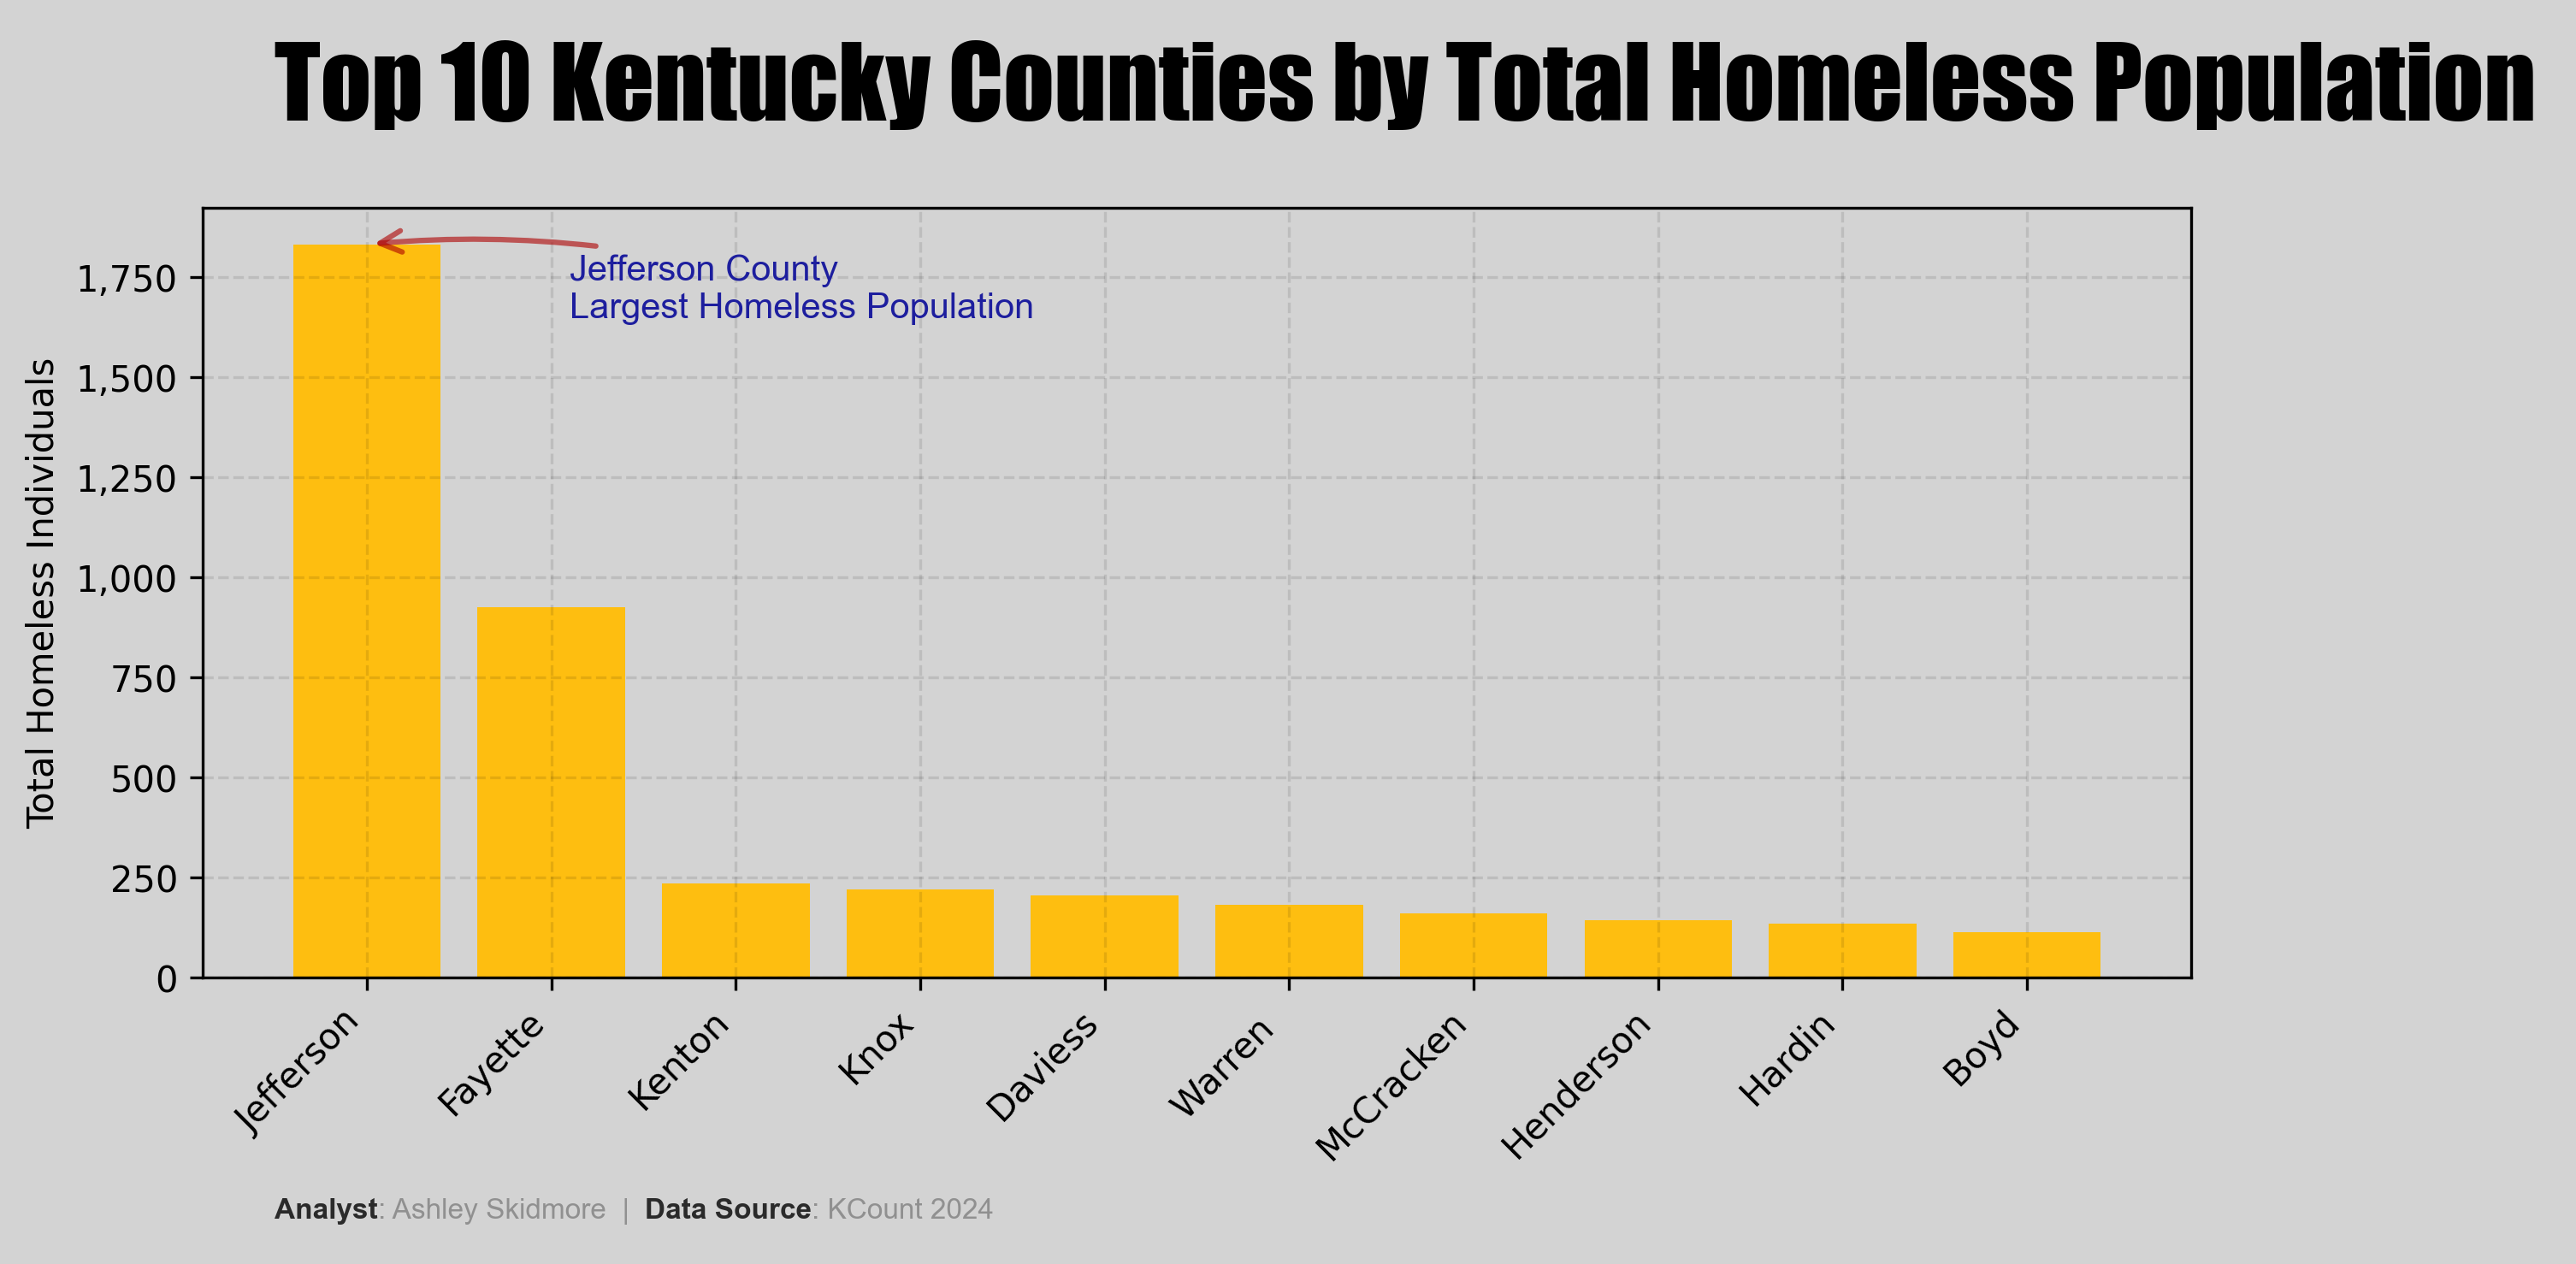

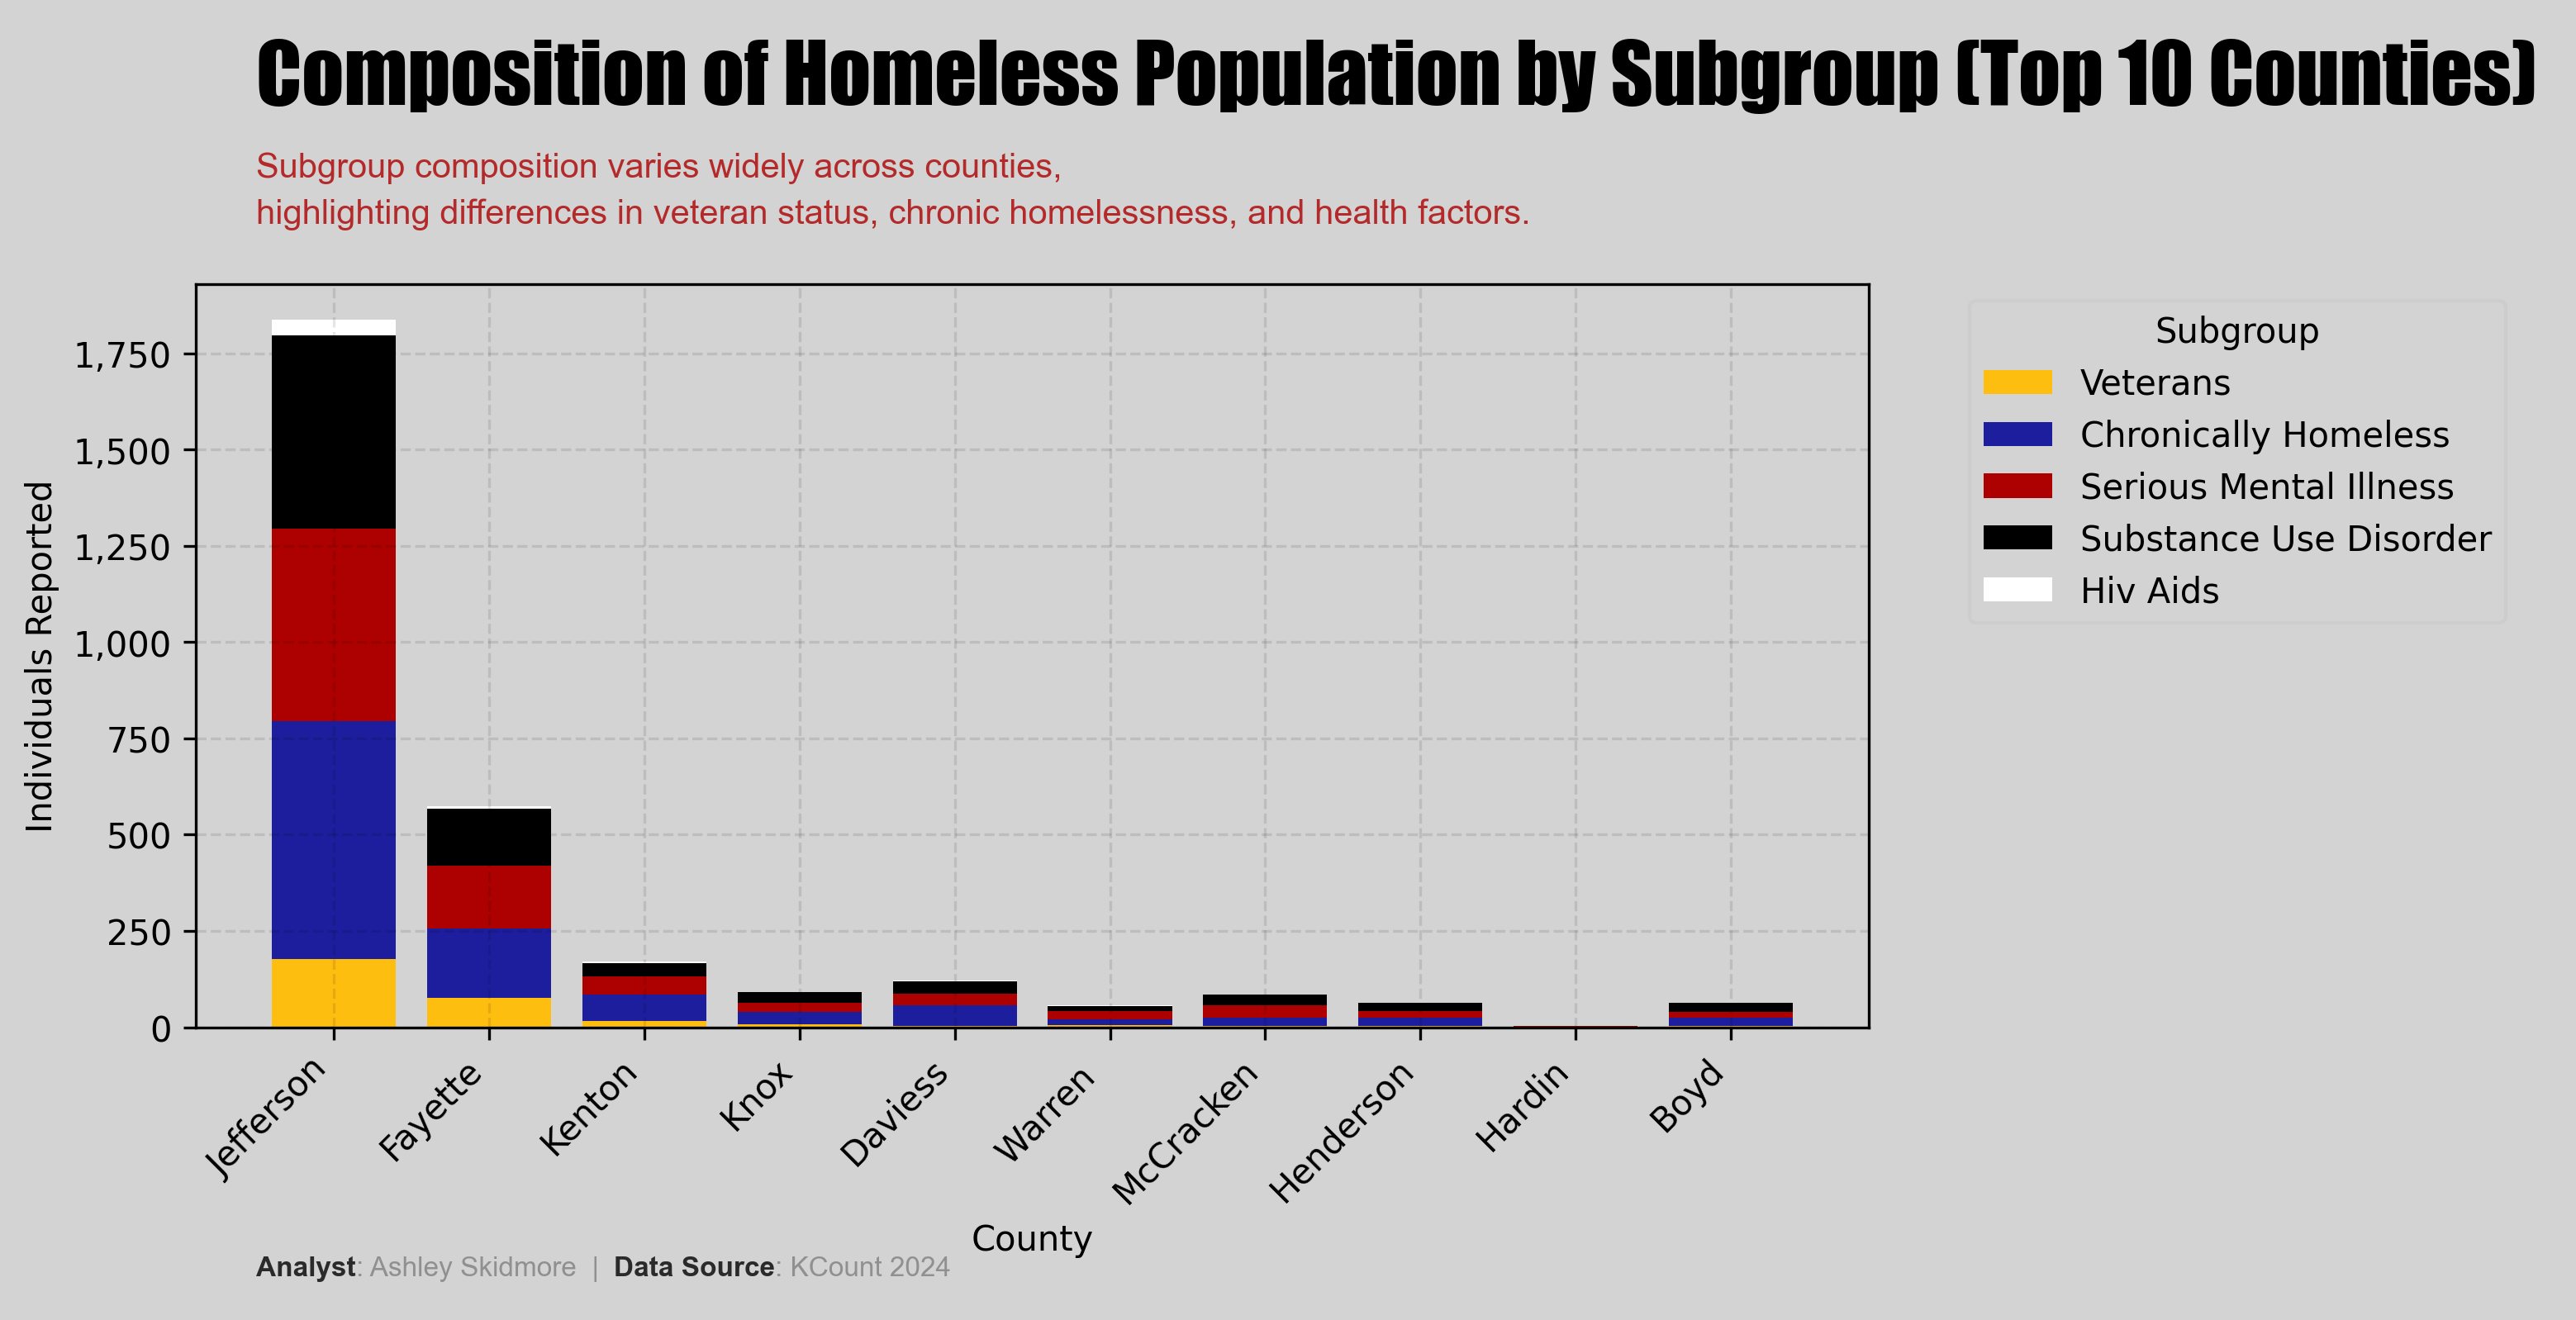

In [36]:
if __name__ == "__main__":
    # --- Read data ---
    kcount_df = get_kcount_data("../ashley/data/k_count.xlsx")
    hud_df = get_hud_data("../ashley/data/hud.xlsx")

    # --- Generate plots ---
    plot_top10_counties(kcount_df)
    plot_homeless_subgroups(kcount_df)


# Keep this file in your project

keep at the bottom of your project

We will go over it later, its a script that will generate a markdown table of contents based on your headings created here in markdown.

In [37]:
import json
import os


def generate_toc_from_notebook(notebook_path):
    """
    Parses a local .ipynb file and generates Markdown for a Table of Contents.
    """
    if not os.path.isfile(notebook_path):
        print(f"❌ Error: File not found at '{notebook_path}'")
        return

    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    toc_markdown = "### **Table of Contents**\n"
    for cell in notebook.get('cells', []):
        if cell.get('cell_type') == 'markdown':
            for line in cell.get('source', []):
                if line.strip().startswith('#'):
                    level = line.count('#')
                    title = line.strip('#').strip()
                    link = title.lower().replace(' ', '-').strip('-.()')
                    indent = '  ' * (level - 1)
                    toc_markdown += f"{indent}* [{title}](#{link})\n"

    print("\n--- ✅ Copy the Markdown below and paste"
          "it into a new markdown cell ---\n")
    print(toc_markdown)


if __name__ == "__main__":
    # Example usage
    notebook_path = 'ashley.ipynb'  # Replace with your notebook path
    generate_toc_from_notebook(notebook_path)


--- ✅ Copy the Markdown below and pasteit into a new markdown cell ---

### **Table of Contents**
    * [**Table of Contents**](#**table-of-contents**)
* [Error Handling](#error-handling)
* [Exploration and Cleaning](#exploration-and-cleaning)
  * [EDA Function](#eda-function)
  * [K Count](#k-count)
  * [HUD](#hud)
* [Plots](#plots)
  * [Functions](#functions)
  * [Highest Homeless Population by County](#highest-homeless-population-by-county)
  * [Subgroups Within the Homeless Population](#subgroups-within-the-homeless-population)
* [Keep this file in your project](#keep-this-file-in-your-project)

